In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import os
from distutils.dir_util import copy_tree, remove_tree

from PIL import Image
from random import randint

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow_addons as tfa
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D


print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.13.0


In [3]:
base_dir = "F:\Alzheimers-ADNI/"
root_dir = "./"
test_dir = base_dir + "test/"
train_dir = base_dir + "train/"
work_dir = root_dir + "Alzheimers-ADNI"

if os.path.exists(work_dir):
    remove_tree(work_dir)
    

os.mkdir(work_dir)
copy_tree(train_dir, work_dir)
copy_tree(test_dir, work_dir)
print("Working Directory Contents:", os.listdir(work_dir))

Working Directory Contents: ['Final AD JPEG', 'Final CN JPEG', 'Final EMCI JPEG', 'Final LMCI JPEG', 'Final MCI JPEG']


In [4]:
WORK_DIR = './Alzheimers-ADNI'

CLASSES = [ 'Final AD JPEG', 'Final CN JPEG', 'Final EMCI JPEG', 'Final LMCI JPEG', 'Final MCI JPEG']

IMG_SIZE = 176
IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)

In [5]:
ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM, batch_size=6500, shuffle=False)

Found 1296 images belonging to 5 classes.


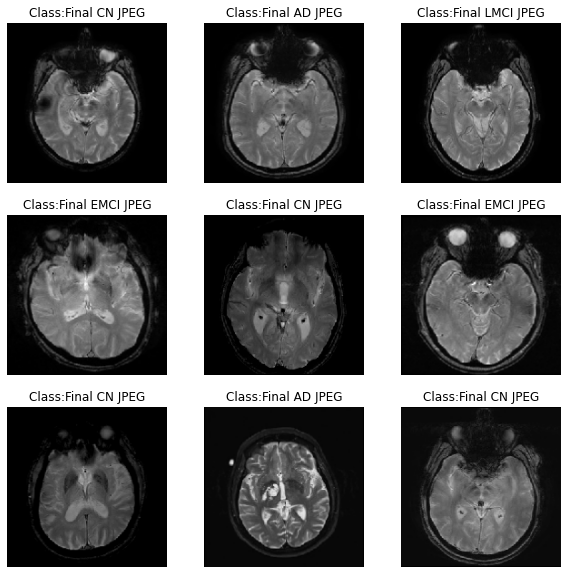

In [7]:
def show_images(generator,y_pred=None):
    """
    Input: An image generator,predicted labels (optional)
    Output: Displays a grid of 9 images with lables
    """
    
    # get image lables
    labels =dict(zip([0,1,2,3,4], CLASSES))
    
    # get a batch of images
    x,y = generator.next()
    
    # display a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0, 1296)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))
                                                     
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
    
# Display Train Images
show_images(train_data_gen)

In [8]:
train_data, train_labels = train_data_gen.next()

In [9]:
print(train_data.shape, train_labels.shape)

(1296, 176, 176, 3) (1296, 5)


In [10]:
sm = SMOTE(random_state=42)  # deal with imbalance dataset 

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(train_data.shape, train_labels.shape)

(2900, 176, 176, 3) (2900, 5)


In [11]:
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [12]:
resnet_model = ResNet101(input_shape=(176, 176, 3), include_top=False, weights="imagenet")

In [13]:
for layer in resnet_model.layers:
    layer.trainable=False

In [18]:
custom_resnet_model = Sequential([
        resnet_model,
        Dropout(0.5),
        GlobalAveragePooling2D(),
        Flatten(),
        BatchNormalization(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(5, activation='softmax')        
    ], name = "resnet_cnn_model")

In [19]:
import keras.backend as K
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [20]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

# CALLBACKS = rop_callback
    
custom_resnet_model.compile(optimizer='rmsprop',
                              loss=tf.losses.CategoricalCrossentropy(),
                              metrics=METRICS)

custom_resnet_model.summary()

Model: "resnet_cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 6, 6, 2048)        42658176  
                                                                 


 dropout_5 (Dropout)         (None, 6, 6, 2048)        0         
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 batch_normalization_5 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 dense_5 (Dense)             (None, 512)               1049088   
                                                                 
 batch_normalization_6 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dropout_6

In [21]:
EPOCHS = 20

history = custom_resnet_model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=EPOCHS,steps_per_epoch=256)

Epoch 1/20
256/256 [==============================] - 412s 2s/step - loss: 2.0556 - accuracy: 0.7529 - precision: 0.2047 - recall: 0.0815 - auc: 0.4978 - f1_score: 0.1126 - val_loss: 1.6525 - val_accuracy: 0.7978 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4918 - val_f1_score: 0.0000e+00
Epoch 2/20
256/256 [==============================] - 280s 1s/step - loss: 1.8544 - accuracy: 0.7720 - precision: 0.1761 - recall: 0.0381 - auc: 0.5109 - f1_score: 0.0566 - val_loss: 1.6431 - val_accuracy: 0.7996 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5104 - val_f1_score: 0.0000e+00
Epoch 3/20
256/256 [==============================] - 185s 723ms/step - loss: 1.7360 - accuracy: 0.7890 - precision: 0.2489 - recall: 0.0273 - auc: 0.5257 - f1_score: 0.0455 - val_loss: 1.6053 - val_accuracy: 0.7996 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5506 - val_f1_score: 0.0000e+00
Epoch 4/20
256/256 [==============================] - 270s 1s/st

In [22]:
#Evaluating the model on the data

#train_scores = model.evaluate(train_data, train_labels)
#val_scores = model.evaluate(val_data, val_labels)
test_scores = custom_resnet_model.evaluate(test_data, test_labels)

#print("Training Accuracy: %.2f%%"%(train_scores[1] * 100))
#print("Validation Accuracy: %.2f%%"%(val_scores[1] * 100))
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

19/19 [==============================] - 41s 2s/step - loss: 1.5232 - accuracy: 0.8003 - precision: 0.5333 - recall: 0.0138 - auc: 0.6407 - f1_score: 0.0252
Testing Accuracy: 80.03%


In [23]:
pred_labels = custom_resnet_model.predict(test_data)

19/19 [==============================] - 39s 2s/step


In [25]:
#Print the classification report of the tested data

#Since the labels are softmax arrays, we need to roundoff to have it in the form of 0s and 1s,
#similar to the test_labels
def roundoff(arr):
    """To round off according to the argmax of each predicted label array. """
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(test_labels, pred_labels, target_names=CLASSES))

                 precision    recall  f1-score   support

  Final AD JPEG       0.25      0.19      0.21       112
  Final CN JPEG       0.32      0.52      0.40       125
Final EMCI JPEG       0.30      0.42      0.35       117
Final LMCI JPEG       0.44      0.47      0.45       116
 Final MCI JPEG       0.25      0.01      0.02       110

      micro avg       0.33      0.33      0.33       580
      macro avg       0.31      0.32      0.29       580
   weighted avg       0.31      0.33      0.29       580
    samples avg       0.33      0.33      0.33       580



In [26]:
import pickle
# save the iris classification model as a pickle file
model_pkl_file = "resnetadni.pkl"  
with open(model_pkl_file, 'wb') as file:  
    pickle.dump(custom_resnet_model, file)